## Topic Modelling

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import sys
import os
#!{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
import gensim.utils
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

C:\Users\dvaro\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
### from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'could', 'also', '&gt', '2', '1', 'https', '0', 'www', 'b', '*', ']' ])

## Loading data

In [4]:
df = pd.read_csv('transform_data.cv')
df = df.fillna("")
df.columns

Index(['id', 'type', 'text', 'created'], dtype='object')

In [5]:
data = list(df['text'])
len(data)

934

## Tokenizing and cleaning data

In [6]:
from gensim.utils import simple_preprocess
def clean_text(texts):
    for sent in texts:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

data_words  = list(clean_text(data))

## Bigrams-Trigrams Models

In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

#!python3 -m spacy download en  # run in terminal once
# or do
# !conda install -c conda-forge spacy-model-en_core_web_md 
# and use nlp=spacy.load('en_core_web_sm') instead in below function.
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm")
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

## Building the topic modelling

In [8]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=20,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.037*"nationwide" + 0.033*"update" + 0.032*"impose" + 0.027*"begin" + '
  '0.025*"ease" + 0.022*"western" + 0.016*"therefore" + 0.015*"instead" + '
  '0.013*"reality" + 0.012*"evident"'),
 (1,
  '0.031*"affect" + 0.023*"sex" + 0.022*"particular" + 0.022*"type" + '
  '0.019*"network" + 0.019*"target" + 0.014*"distribution" + 0.014*"practice" '
  '+ 0.014*"contact_trace" + 0.012*"secondary"'),
 (2,
  '0.051*"positive" + 0.032*"group" + 0.026*"peak" + 0.020*"source" + '
  '0.020*"boost" + 0.018*"participant" + 0.017*"wave" + 0.014*"sample" + '
  '0.012*"trial" + 0.012*"aged"'),
 (3,
  '0.027*"covid" + 0.025*"people" + 0.022*"lockdown" + 0.020*"study" + '
  '0.016*"high" + 0.012*"pandemic" + 0.012*"child" + 0.012*"year" + '
  '0.011*"risk" + 0.010*"low"'),
 (4,
  '0.000*"bodsphere" + 0.000*"yoga" + 0.000*"rethink" + 0.000*"groupthink" + '
  '0.000*"execute" + 0.000*"puppy" + 0.000*"bridge" + 0.000*"tracker" + '
  '0.000*"harmful" + 0.000*"seismic"'),
 (5,
  '0.042*"rule" + 0.041*"

## Dominant topics and percentage distribution

In [9]:
pd.set_option('display.max_colwidth', -1)

<ipython-input-9-0891b765a168>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [10]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Doc No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic

,Doc No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.3655,"positive, group, peak, source, boost, participant, wave, sample, trial, aged","[default, source, coronaviruse, still, lockdown, take, need, intensive_care, make, patient, alive, recover, need, facility, keep, motility, low, advisor, press, conference, say, go, build, hospital, containment, facility]"
1,1,2.0,0.7514,"positive, group, peak, source, boost, participant, wave, sample, trial, aged","[clinic, percentage, sample, tested_positive, covid, virus, decrease, time, positive, approximately, fever, clinic, screening, positive, page, default, source, coronaviruse, correctly, peak, mention, shortly, afterward, province]"
2,2,3.0,0.8862,"covid, people, lockdown, study, high, pandemic, child, year, risk, low","[say, basically, chance, proper, think, populace, accept, disease, kill, rate, similar, almost, case, side, effect, bad, covid, reasonable, social_distance, hand, washing, remote, work, maybe, curfew, system, probably, bad, case, scenario, agree, number, think, disease, absolutely, everywhere, start, random, antibody, test, different, region, confirm, operate, assumption, idea, rate, severity, disease, low, number, indicate, half, people, run, mild, cough, girlfriend, get, random, day, sore, throat, fever, disappear, likely, disease, covid, literally, way, know, many, people, disease, hit, nursing_home, high, volume, risk, people]"
3,3,6.0,0.6754,"case, lockdown, virus, test, spread, country, vaccine, measure, large, impact","[risk, people, hour, worth, statement, save, million, inconsistent, current, datum, less, death, date, majority, age, ccfr, consistently, fall, get, better, characterize, treat, cv, mitigation, strategy, broadly, implement, world, prove, effective, slow, spread, country, reverse, entirely, face, serious, public_health, threat, appear, broad, doomsday, level, scenario, especially, north_america, excellent, forewarn, grow, knowledge, avoid, mitigate, specific, confluence, event, blindside, early, tip, downward, spiral, last, hour, major, sport, league, cancel, season, plane, fly, empty, extent, airline, furlough, worker, major, employer, apple, switch, work, home, wherever, possible, university, switch, online, rest, school, year, cancel, baseball, volleyball, soccer, park, normally, full, kid, afternoon, play, team, sport, ...]"
4,4,6.0,0.9383,"case, lockdown, virus, test, spread, country, vaccine, measure, large, impact","[strongly, disagree, know, never, possible, believe, never, possible, base, know, stop, fully, containment, strategy, work, area, large, populous, nation, nation, strike, first, already, progress, containment, mitigation, strategy, recent, week, section, south, korean, city, change, tactic, surge, represent, new, phase, outbreak, argue, authority, adapt, response, first, focused, tracking, suspect, case, quarantine, say, point, trace, infection, spread, meaningless, tracing, take, many, resource, say, add, city, enough, epidemiological, investigator, virus, widespread, investigator, longer, sort, infect, hyeonggab, doctor, say, see, shift, tactic, health, authority, try, contain, trace, virus, try, mitigate, impact, prevent, death, reportedly, chinese, lockdown, containment, thoroughly, yet, even, degree, measure, see, authoritarian, ...]"
...,...,...,...,...,...
929,929,9.0,0.4342,"case, infection, prevalence, increase, report, transmission, result, day, epidemic, period","[interested, article, qeio, impact, lockdown, incidence, prevalence, mortality, second_wave, pandemic, observational, analysis, bihar]"
930,930,0.0,0.2200,"nationwide, update, impose, begin, ease, western, therefore, instead, reality, evident","[live, update, drive, outbreak]"
931,931,8.0,0.4102,"death, covid, cause, follow, excess, impact, intervention, mortality, keep, non","[enter, nationwide, covid, case]"
932,932,8.0,0.4102,"death, covid, cause, follow, excess, impact, intervention, mortality, keep, non","[enter, nationwide, covid, case]"


## Most representative sentence for each topic

In [11]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = -1

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet

<ipython-input-11-ca52132e074e>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.options.display.max_colwidth = -1


,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.6402,"nationwide, update, impose, begin, ease, western, therefore, instead, reality, evident","[dcamp, charmingly, naive, cat, ethical, problem, fairness, say, none, enjoy, significant, freedom, enjoy, freedom, ease, ease]"
1,1.0,0.3359,"affect, sex, particular, type, network, target, distribution, practice, contact_trace, secondary","[happen, partial, lockdown, say, worker, meat, packing, plant, family, get, sick, covid, stop, circulate, particular, herd, network, people, school, open, meat, pack, herd, connect, herd, wave, infection, remain, meat, packer, infected, first_wave, explain, weird, wave, dynamic, observe]"
2,2.0,0.7514,"positive, group, peak, source, boost, participant, wave, sample, trial, aged","[clinic, percentage, sample, tested_positive, covid, virus, decrease, time, positive, approximately, fever, clinic, screening, positive, page, default, source, coronaviruse, correctly, peak, mention, shortly, afterward, province]"
3,3.0,0.9729,"covid, people, lockdown, study, high, pandemic, child, year, risk, low","[month, cost, month, assume, lockdown, take, one, life, time, cost, healthy, life, control, measure, become, infected, percent, lose, week, mild, month, hospitalization, recovery, remain, critical_care, lose, enough, lung, capacity, lose, life, die, lose, life, assume, healthcare, overburden, calculate, loss, month, entire, population, pretty, much, live, bulk, death, occur, elderly, hence, lose, less, month, life, calculation, however, scenario, healthcare, malady, essentially, unavailable, add, cost, hand, many, lockdown, take, away, one, life, time, people, mostly, continue, live, learn, love, even, coope, home, different, assumption, obviously, different, result, look, broadly, comparable, tangible, consequence, lockdown, break, transmission, chain, faire, permit, almost, population, die, bring, ...]"
4,4.0,0.1000,"bodsphere, yoga, rethink, groupthink, execute, puppy, bridge, tracker, harmful, seismic",[richardson]
5,5.0,0.3667,"rule, range, local, combination, achieve, elimination, detection, employ, distribute, tail","[late, rule]"
6,6.0,0.9522,"case, lockdown, virus, test, spread, country, vaccine, measure, large, impact","[come, somewhere, paper, government, request, wear_mask, go, pretty, sure, influenza, ill, dig, find, analysis, government, recommendation, stay, home, wear_mask, time, even, clear, decrease, new, case, correlate, nicely, day, italian, datum, show, decrease, regional, lockdown, day, significant, national, reason, image, upload]"
7,7.0,0.5250,"model, great, estimate, figure, include, viral, sars_cov, associate, finding, seroprevalence","[attendance, implementation, study]"
8,8.0,0.7174,"death, covid, cause, follow, excess, impact, intervention, mortality, keep, non","[comment, thread, claim, complete, lockdown, year, minimum, heavily, upvoted, stuff, scare, require, destruction, civil, liberty, economic, collapse, like, never, see, people, keep, say, politician, think, people, want, even, expert, tell, terrible, idea]"
9,9.0,0.7000,"case, infection, prevalence, increase, report, transmission, result, day, epidemic, period","[infection, decline]"


## Word count of topic Keywords

In [12]:
topics

NameError: name 'topics' is not defined

<ipython-input-13-4cccd54c799e>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-13-4cccd54c799e>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-13-4cccd54c799e>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-13-4cccd54c799e>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-13-4cccd54c799e>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation

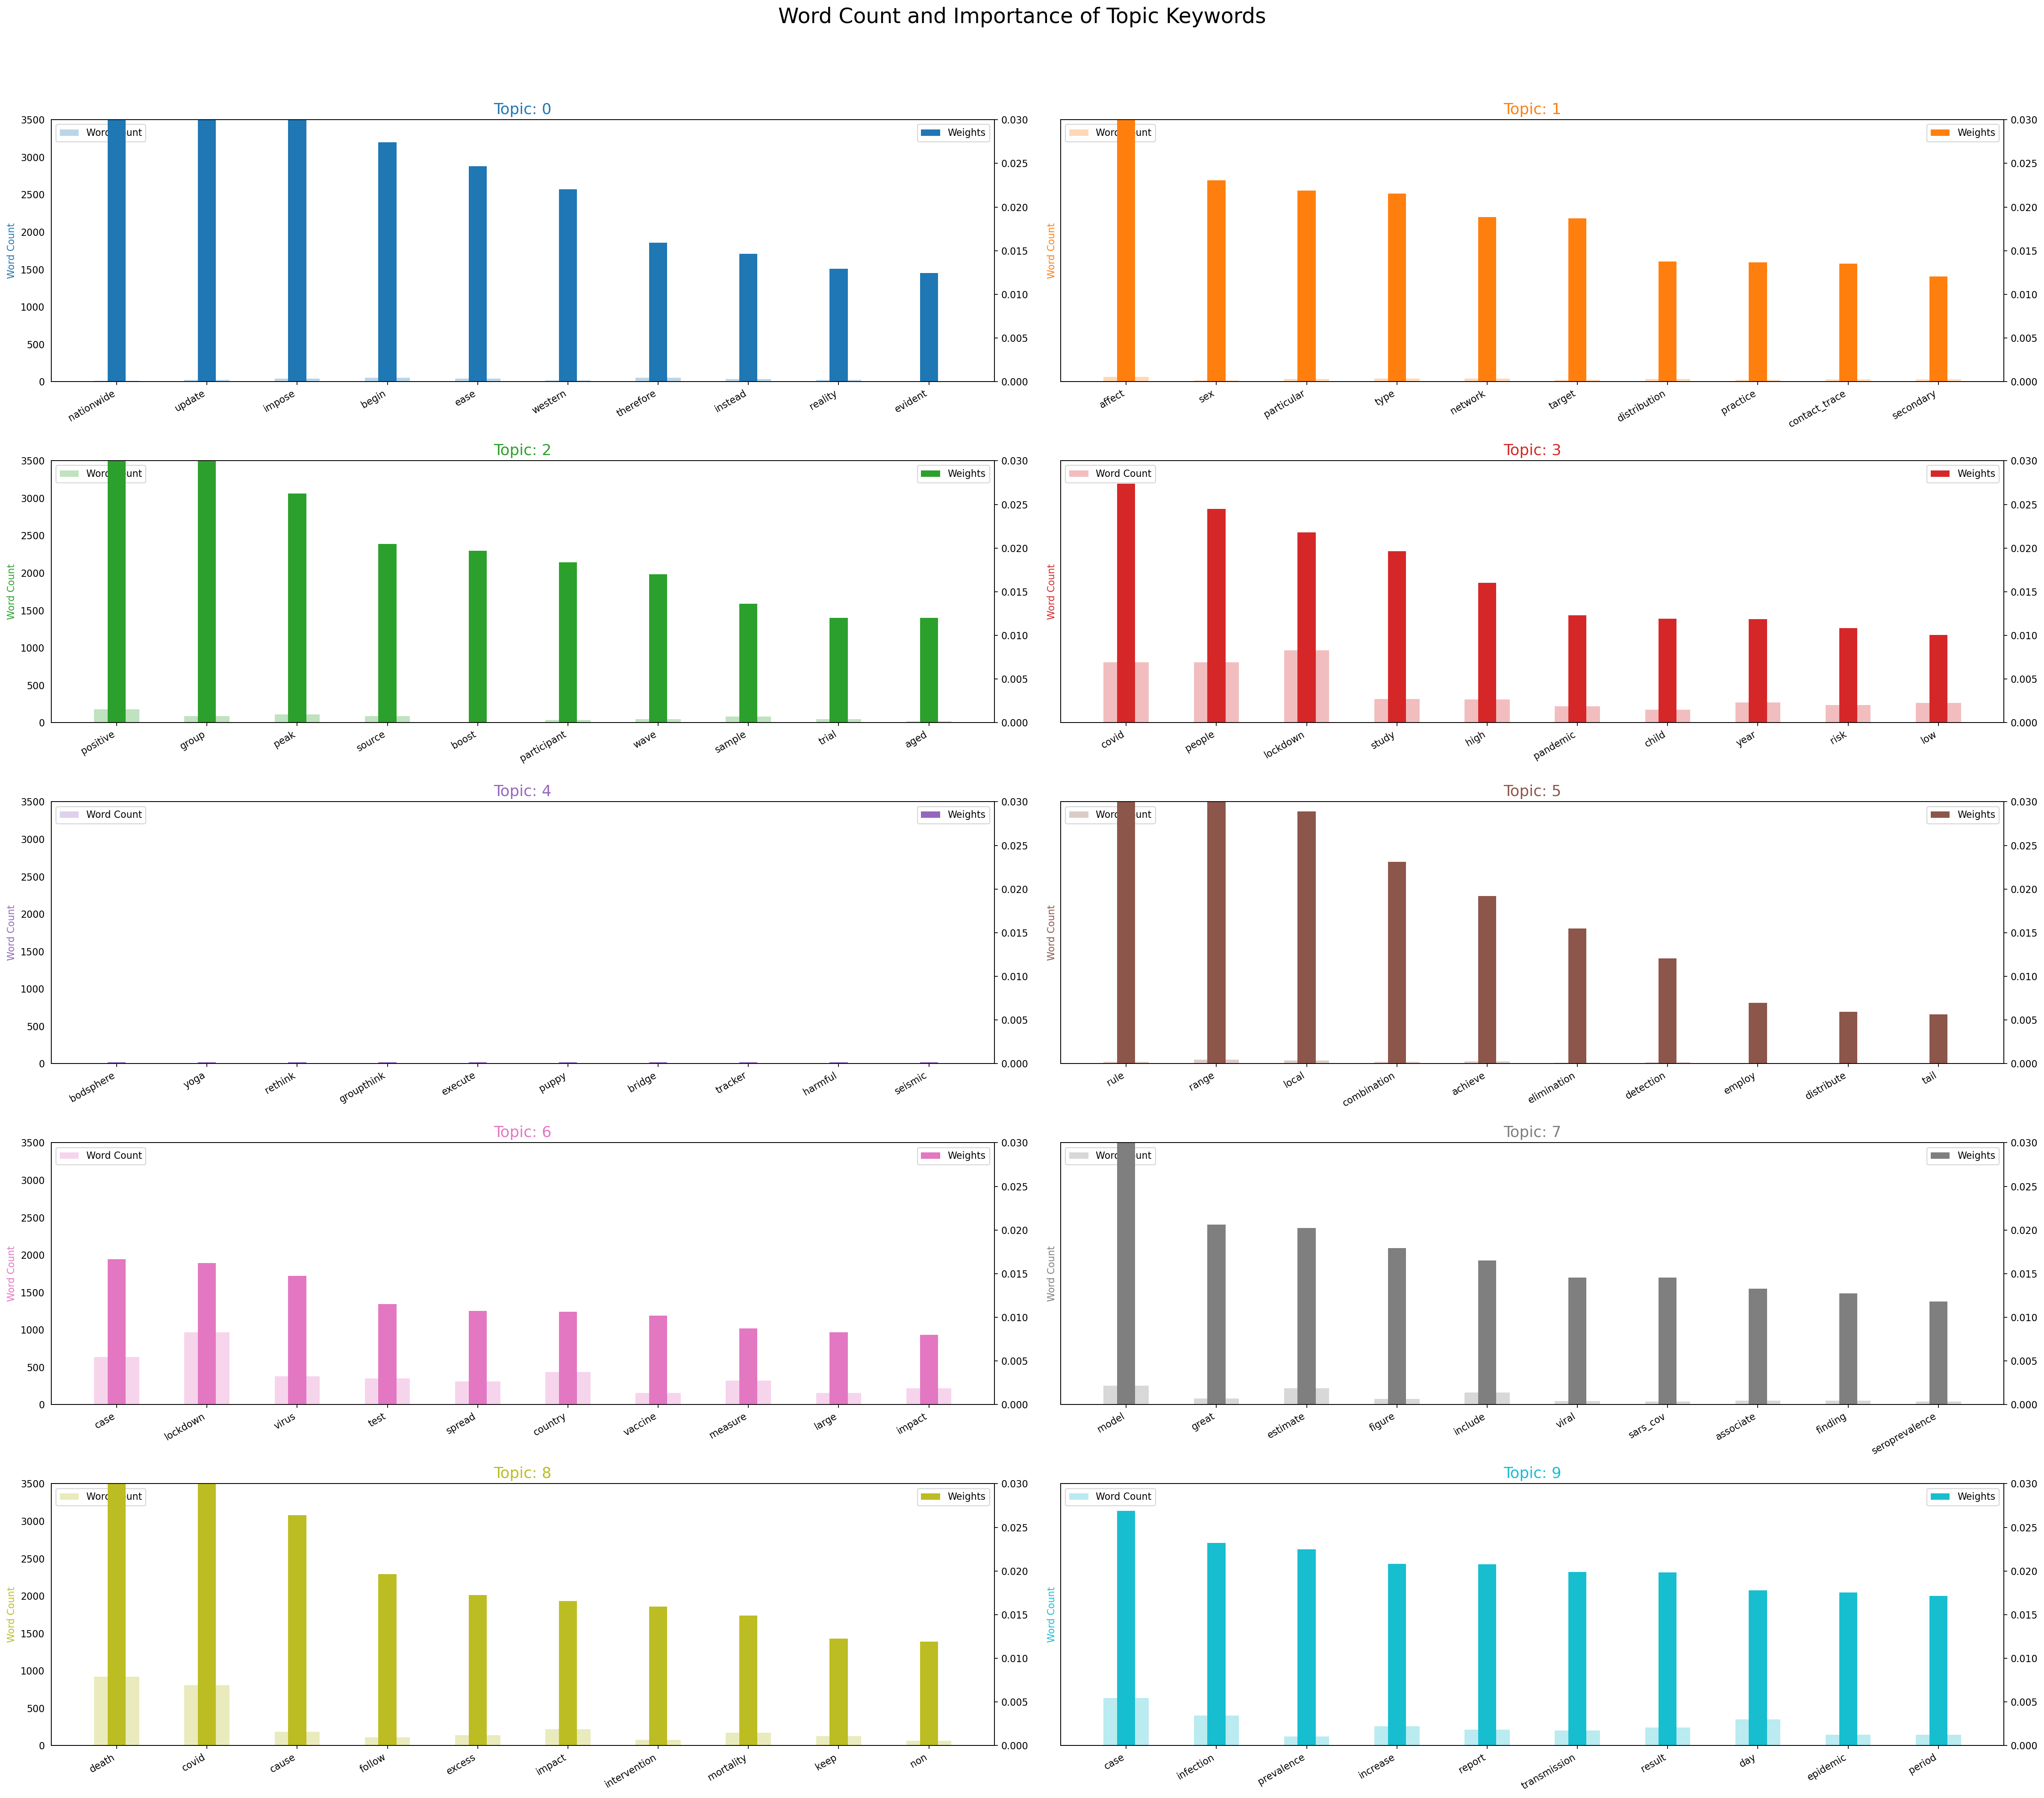

In [13]:
from collections import Counter
from matplotlib import colors as mcolors
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(30,25), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## What are the most discussed topics in the documents?

In [14]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

##### 1- The number of documents for each topic by assigning the document to the topic that has the most weight in that document.
#### 2- The number of documents for each topic by by summing up the actual weight contribution of each topic to respective documents.

In [15]:
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('talk')

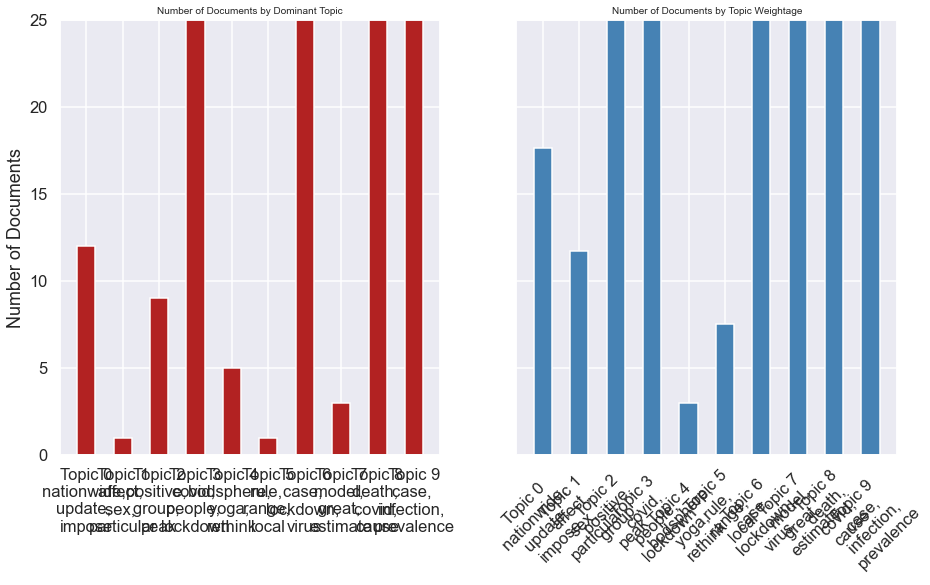

In [16]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8),sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 25)
plt.xticks(rotation=45)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.xticks(rotation=45)
plt.show()

## t-SNE Clustering Chart

In [17]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 10
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 781 samples in 0.003s...
[t-SNE] Computed neighbors for 781 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 781 / 781
[t-SNE] Mean sigma: 0.107688
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.167427
[t-SNE] KL divergence after 1000 iterations: 0.544206


Loading BokehJS ...